In [157]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display
#import pyhash
import gensim
from gensim.test.utils import common_texts, get_tmpfile
import multiprocessing as mp
from joblib import Parallel, delayed
import concurrent.futures
from pprint import pprint
import random
import mpld3
import re
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cluster
from sklearn import manifold
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import Normalizer, normalize, scale

%matplotlib inline

# Enable mpld3 for notebook
mpld3.enable_notebook()

# Instantiate hasher object
#hasher = pyhash.city_64()

# Method to strip white test
def strip(text):
    return text.strip()

# Method to set dataframe entries to integers
def make_int(text):
    return int(text.strip(''))    

# Method to match IP against flow srcIP
def sort_ip_flow(ip):
    # List to house flows when matches
    flows_list = []
    # Iterate over tcp_flows list
    for flow in tcp_flows:   
        # Comparison logic - flow[1][3] corresponds to SrcIP in flow tuple
        if ip == flow[1][3]:        
            # Append match to flows_list
            flows_list.append(flow)
    # Return dictionary of IPs and flows
    return {ip: flows_list}

def process_flow(flow):    
    # Create hash of protocol
    proto_hash = hasher(flow[1][2])        
    # Create hash of SrcIP
    srcip_hash = hasher(flow[1][3])        
    # Create hash of Sport
    srcprt_hash = hasher(flow[1][4]) 
    # Create hash of DstIP
    dstip_hash = hasher(flow[1][6])    
    # Create hash of Dport
    dstprt_hash = hasher(flow[1][7]) 
    # Cast flow entry as list for manipulation
    flow_list = list(flow)       
    # Insert hashes as entry in tuple for each flow
    flow_list.insert(4, (str(proto_hash), str(srcip_hash), str(srcprt_hash), 
                         str(dstip_hash), str(dstprt_hash)))    
    # Re-cast flow entry as tuple w/ added hash tuple
    flow = tuple(flow_list)
    return(flow)

def single_hash(flow):
    flow_hash = hasher(flow)
    flow_list = list(flow)
    flow_list.insert(4, str(flow_hash))
    flow = tuple(flow_list) 
    return(flow)
    

In [3]:
# Import netflow capture file(s)

flowdata = pd.DataFrame()

cap_files = ["/workspace/datasets/ctu-13-dataset/CTU-13-Dataset/1/capture20110810.binetflow",
             "/workspace/datasets/ctu-13-dataset/CTU-13-Dataset/2/capture20110811.binetflow"]

for f in cap_files:
    frame = pd.read_csv(f, sep=',', header=0)
    flowdata = flowdata.append(frame, ignore_index=True)

# Strip whitespace
flowdata.rename(columns=lambda x: x.strip(), inplace = True)

In [4]:
subsample_cats = flowdata.loc[:,['Proto', 'SrcAddr', 'DstAddr', 'Dport']]
subsample_labels = flowdata.loc[:,['Label']]

subsample_cats_labels = flowdata.loc[:,['Proto', 'SrcAddr', 'DstAddr', 'Dport', 'Label']]

## Word2vec (co-occurrence idea for flow data)

Attempting to find some co-occurrence patterns in the flow data according to how an algorithm like word2vec, in its skip-gram implementation specifically for this work, works. The idea is that flows, $V_{f}$ for vector representation, that occur within a window $W_{f}$, which can be modeled as "time" using timestamps from the capture. A visual representation of a single flow and window of flows can be seen below :

<img src="flow_window_5.jpg">

The image doesn't display the time-stamp, but the windowing will be done according to a selected time window.

Considering the conditional probabilities $P(w|f)$, with a given set of flow captures _Captures_, the goal is to set the parameters $\theta$ of $P(w|f;\theta)$ so as to maximize the capture probability :

$$\underset{\theta}{\operatorname{argmax}} \underset{f \in Captures}{\operatorname{\prod}} \left[\underset{w \in W_{f}}{\operatorname{\prod}} P(w \vert f;\theta)\right] $$

in this equation $W_{f}$ is a set of surrounding flows of flow $f$. Alternatively :

$$ \underset{\theta}{\operatorname{argmax}} \underset{(f, w) \in D}{\operatorname{\prod}} P(w \vert f;\theta) $$

Here $D$ is the set of all flow and window pairs we extract from the text.

The word2vec algorithm seems to capture an underlying phenomenon of written language that clusters words together according to their linguistic similarity, this can be seen in something like simple synonym analysis. The goal is to exploit this underlying "similarity" phenomenon with respect to co-occurrence of flows in a given flow capture.

Each "time step", right now just being a subset of a given flow data set, is as a 'sentence' in the word2vec model. We should then be able to find flow "similarities" that exist within the context of flows. The idea is this "similarity" will really just yield an occurrence pattern over the flow data, much like word2vec does for written text.

Another part of the idea is much like in written text there are word / context, $(w,c)$, patterns that are discovered and exploited when running the algorithm over a given set of written language. There are common occurrences and patterns that can be yielded from flow data, much like the occurrences and patterns that are yielded from written text.

At the end of the embedding exercise we can use k-means to attempt to cluster flows, according to the embedding vectors that are produced through the word2vec algorithm. This should yield some sort of clustering of commonly occurring flows that have the same occurrence measure in a given set of Netflow captures. We can then use this data to measure against other, unseen, flows for future classification of "anomaly". I use that word loosely as this is strictly experimental.

### Assumptions :

#### Maximizing the objective will result in good embeddings $v_{f}  \forall w \in V$

##### _It is important to note with the above statement, with respect to time, is the assumption that the data I am operating from has already been ordered according to the tooling I used to acquire it_

## Skip-gram Negative Sampling

One of the other portions of the word2vec algorithm that I will be testing in this experiment will be negative sampling.

The objective of Skip-gram with Negative Sampling is to maximize the the probability that $(f,w)$ came from the data $D$. This can be modeled as a distribution such that $P(D=1|f,w)$ be the probability that $(f,w)$ came from the data and $P(D=0|f,w) = 1 - P(D=1|f,w)$ the probability that $(f,w)$ did not. 

The distribution is modeled as :

$$P(D=1|f,w) = \sigma(\vec{f} \cdot \vec{w}) = \frac{1}{1+e^{-\vec{f} \cdot \vec{w}}}$$

where $\vec{f}$ and $\vec{w}$ (each a d-dimensional vector) are the model parameters to be learned.

The negative sampling tries to maximize $P(D=1|f,w)$ for observed $(f,w)$ pairs while maximizing $P(D=0|f,w)$ for stochastically sampled "negative" examples, under the assumption that selecting a context for a given word is likely to result in an unobserved $(f,w)$ pair.

SGNS's objective for a single $(f,w)$ output observation is then:

$$ \mathbb{E} = \log \sigma(\vec{f} \cdot \vec{w}) + k \cdot \mathbb{E}_{w_{N} \sim P_{D}} [\log \sigma(\vec{-f} \cdot \vec{w}_N)] $$

where $k$ is the number of "negative" samples and $w_{N}$ is the sampled window, drawn according to the empirical unigram distribution $P_{D}(w) = \frac{\#w}{|D|}$ 

This object is then trained in an online fashion using stochastic gradient updated over the observed pairs in the corpus $D$. The goal objective then sums over the observed $(f,w)$ pairs in the corpus :

$$ \ell = \Sigma_{f \in V_{f}} \Sigma_{w \in V_{w}} \#(f,w)(\log \sigma(\vec{f} \cdot \vec{w}) + k \cdot \mathbb{E}_{w_{N} \sim P_{D}} [\log \sigma(\vec{-f} \cdot \vec{w}_N)]$$

Optimizing this objective groups flows that have similar embeddings, while scattering unobserved pairs.



#### TODO (further exploration) :

<ul class="contains-task-list">
  <li class="task-list-item">
  <input class="task-list-item-checkbox" id="" type="checkbox"> Implement timestamp window oriented 'sentence' creation, current implementation created same length flow 'sentences' for every $f$ flow</li>
</ul>

In [5]:
# Method to slide window over dataframe of 
# flowdata and create "sentences"

def create_corpora(dataframe, window, corpus_count):
    corpus = []
    corpora = []
    begin = 0
    end = 0
    for i in range(corpus_count):
        while end <= window:
            end += 1
        else:
            corpus.append(dataframe[begin:(end-1)])
        begin = begin + window
        end = end + window
    corpora.append(corpus)
    return(corpora)

In [6]:
corpora = create_corpora(subsample_cats, 30, len(subsample_cats))
labels = create_corpora(subsample_labels, 30, 153333)
corpora_labels = create_corpora(subsample_cats_labels, 30, len(subsample_cats_labels))

In [7]:
# Check if any of the nan values which are cast as floats on dataframe creation still exist
# manual inspection for the time being.
# index = 0

# for i in corp1.values.tolist():
#     index += 1
#     for v in i:
#         if type(v) != str:
#             print(type(v))
#             print(index)

In [8]:
# Convert all tuples created by previous create_corpora function
# to strings for use with tokenization which is then used in the
# word2vec algorithm below 

str_corpora = []

for corpus in corpora[0]:
    stringify = []
    for sentence in corpus.values.tolist():
        stringify.append(str(sentence))
    str_corpora.append(stringify)

In [9]:
str_corpora[0]

["['tcp', '94.44.127.113', '147.32.84.59', '6881']",
 "['tcp', '94.44.127.113', '147.32.84.59', '6881']",
 "['tcp', '147.32.86.89', '77.75.73.33', '80']",
 "['tcp', '147.32.86.89', '77.75.73.33', '80']",
 "['tcp', '147.32.86.89', '77.75.73.33', '80']",
 "['tcp', '147.32.86.89', '77.75.73.33', '80']",
 "['tcp', '213.200.244.217', '147.32.84.59', '6881']",
 "['tcp', '75.105.28.60', '147.32.84.59', '6881']",
 "['tcp', '75.105.28.60', '147.32.84.59', '6881']",
 "['tcp', '178.111.79.115', '147.32.84.229', '13363']",
 "['tcp', '147.32.84.59', '147.32.80.7', '80']",
 "['tcp', '75.105.28.60', '147.32.84.59', '6881']",
 "['tcp', '89.31.40.106', '147.32.84.59', '6881']",
 "['tcp', '89.31.40.106', '147.32.84.59', '6881']",
 "['tcp', '188.112.70.72', '147.32.84.59', '6881']",
 "['tcp', '85.248.56.40', '147.32.84.59', '6881']",
 "['tcp', '41.188.145.202', '147.32.84.229', '13363']",
 "['tcp', '41.188.145.202', '147.32.84.229', '443']",
 "['tcp', '41.188.145.202', '147.32.84.229', '80']",
 "['tcp', 

In [10]:
str_corpora_labels = []

for corpus in corpora_labels[0]:
    stringify_labels = []
    for sentence in corpus.values.tolist():
        stringify_labels.append(str(sentence))
    str_corpora_labels.append(stringify_labels)

In [11]:
str_corpora_labels[0]

["['tcp', '94.44.127.113', '147.32.84.59', '6881', 'flow=Background-Established-cmpgw-CVUT']",
 "['tcp', '94.44.127.113', '147.32.84.59', '6881', 'flow=Background-Established-cmpgw-CVUT']",
 "['tcp', '147.32.86.89', '77.75.73.33', '80', 'flow=Background-TCP-Attempt']",
 "['tcp', '147.32.86.89', '77.75.73.33', '80', 'flow=Background-TCP-Attempt']",
 "['tcp', '147.32.86.89', '77.75.73.33', '80', 'flow=Background-TCP-Attempt']",
 "['tcp', '147.32.86.89', '77.75.73.33', '80', 'flow=Background-TCP-Attempt']",
 "['tcp', '213.200.244.217', '147.32.84.59', '6881', 'flow=Background-Established-cmpgw-CVUT']",
 "['tcp', '75.105.28.60', '147.32.84.59', '6881', 'flow=Background-Established-cmpgw-CVUT']",
 "['tcp', '75.105.28.60', '147.32.84.59', '6881', 'flow=Background-Established-cmpgw-CVUT']",
 "['tcp', '178.111.79.115', '147.32.84.229', '13363', 'flow=Background-TCP-Established']",
 "['tcp', '147.32.84.59', '147.32.80.7', '80', 'flow=Background-Established-cmpgw-CVUT']",
 "['tcp', '75.105.28.60

In [12]:
# Here we train a model without using the negative sampling hyperparameter 
# We will be using this for testing of accuracy of model vs. using the 
# negative sampling function

flow_model = gensim.models.Word2Vec(str_corpora, workers=8, size=200, window=20, min_count=1)

In [13]:
# Here we train a model without using the negative sampling hyperparameter 
# We will be using this for testing of accuracy of model vs. using the 
# negative sampling function

flow_model_labels = gensim.models.Word2Vec(str_corpora_labels, workers=8, size=200, window=20, min_count=1)

In [14]:
# Here we train a model using the negative sampling which we will then compare
# to the model above for the impact that the negative sampling has on the 
# clustering of flows

flow_model_sgns = gensim.models.Word2Vec(str_corpora, workers=23, size=100, window=30, negative=10, sample=5)

In [15]:
# Here we train a model using the negative sampling which we will then compare
# to the model above for the impact that the negative sampling has on the 
# clustering of flows

flow_model_sgns_labels = gensim.models.Word2Vec(str_corpora_labels, workers=23, size=100, 
                                                window=30, negative=10, sample=5)

## Preliminary results (very rough, no real hyperparameter tunings / exploration, etc.)

We can see below the results may prove to be useful with respect to certain labels present in the dataset, but not others. This may have to do with the raw occurence rates of certain flow and window #$(f,w)$ combinations vs. others. I use labels lightly as well as this will ultimately become an exercise of semi-supervised learning as it can sometimes be impossible for humans to interpret the results of an unsupervised learning task without any type of contextual insight, as labels can provide. In the case of written language, the "insight" that is provided is the fact that we know what the meanings of words are within the language and if they're clustering correctly, re: synonyms and antonyms, etc.

We can tune for this using subsampling above in the SGNS model. Which will we do next.

#### TODO:

<ul class="contains-task-list">
  <li class="task-list-item">
  <input class="task-list-item-checkbox" id="" type="checkbox"> GridSearch for hyperparameters </li>
</ul>


Here we see that there is indeed a clustering that has happened with respect to the "From-Botnet-V42-UDP-DNS"

In [16]:
# Test for flow similarity, preferrably a flow that has the botnet label

flow_model.wv.similar_by_word("['udp', '84.215.89.9', '147.32.84.229', '13363']")

[("['udp', '147.32.84.229', '24.226.180.73', '24431']", 0.9048817157745361),
 ("['tcp', '147.32.86.99', '94.138.111.53', '80']", 0.8970801830291748),
 ("['udp', '86.100.50.11', '147.32.84.229', '13363']", 0.8969946503639221),
 ("['udp', '66.58.129.201', '147.32.84.229', '13363']", 0.8919668197631836),
 ("['udp', '70.181.100.200', '147.32.84.229', '13363']", 0.8883332014083862),
 ("['tcp', '147.32.84.59', '62.107.199.69', '8453']", 0.8882638216018677),
 ("['udp', '220.128.219.107', '147.32.84.229', '13363']", 0.8878185153007507),
 ("['icmp', '147.32.84.171', '82.31.241.156', '0xe11a']", 0.8876680731773376),
 ("['udp', '147.32.84.229', '187.105.22.143', '61837']", 0.8871304988861084),
 ("['tcp', '188.132.214.130', '147.32.87.101', '6705']", 0.8865007162094116)]

In [17]:
# Test for flow similarity, preferrably a flow that has the botnet label

flow_model.wv.similar_by_word("['tcp', '147.32.84.165', '217.163.21.34', '80']")

[("['tcp', '147.32.84.165', '173.241.240.4', '80']", 0.98732590675354),
 ("['tcp', '147.32.84.165', '184.82.148.43', '80']", 0.9869464635848999),
 ("['tcp', '147.32.84.165', '184.82.147.251', '80']", 0.9847996234893799),
 ("['tcp', '147.32.84.165', '64.12.90.34', '25']", 0.9845278263092041),
 ("['tcp', '147.32.84.165', '50.22.198.84', '80']", 0.9843739867210388),
 ("['tcp', '147.32.84.165', '74.6.136.65', '25']", 0.9840825796127319),
 ("['tcp', '147.32.84.165', '98.139.175.225', '25']", 0.9838323593139648),
 ("['tcp', '147.32.84.165', '64.12.90.97', '25']", 0.9831916689872742),
 ("['tcp', '147.32.84.165', '98.139.175.224', '25']", 0.9828494787216187),
 ("['tcp', '147.32.84.165', '205.188.59.193', '25']", 0.9827703237533569)]

In [18]:
flow_model_labels.wv.most_similar("['tcp', '147.32.84.165', '60.190.223.75', '888', 'flow=From-Botnet-V42-TCP-CC6-Plain-HTTP-Encrypted-Data']")

[("['udp', '114.44.109.17', '147.32.84.229', '13363', 'flow=Background-UDP-Established']",
  0.951949954032898),
 ("['icmp', '89.235.37.130', '147.32.84.122', '0x692d', 'flow=Background']",
  0.9513915181159973),
 ("['udp', '77.161.245.26', '147.32.84.229', '13363', 'flow=Background-UDP-Established']",
  0.9506394267082214),
 ("['udp', '95.43.236.235', '147.32.84.229', '13363', 'flow=Background-UDP-Established']",
  0.9505306482315063),
 ("['udp', '147.32.84.229', '114.38.40.237', '9789', 'flow=Background-UDP-Established']",
  0.9503170847892761),
 ("['udp', '204.191.84.11', '147.32.84.229', '13363', 'flow=Background-UDP-Established']",
  0.9499182105064392),
 ("['udp', '46.44.36.22', '147.32.84.229', '13363', 'flow=Background-UDP-Established']",
  0.9486029148101807),
 ("['udp', '87.120.213.137', '147.32.84.229', '13363', 'flow=Background-UDP-Established']",
  0.9479526281356812),
 ("['udp', '94.156.163.185', '147.32.84.229', '13363', 'flow=Background-UDP-Established']",
  0.947588086

In [19]:
flow_model_labels.wv.most_similar("['tcp', '147.32.84.165', '217.163.21.34', '80', 'flow=From-Botnet-V43-TCP-Established-HTTP-Ad-34']", topn=10)

[("['tcp', '147.32.84.165', '98.139.175.224', '25', 'flow=From-Botnet-V43-TCP-Attempt-SPAM']",
  0.9898767471313477),
 ("['tcp', '147.32.84.165', '217.163.21.37', '80', 'flow=From-Botnet-V43-TCP-Established-HTTP-Ad-45']",
  0.9894694685935974),
 ("['tcp', '147.32.84.165', '205.188.146.193', '25', 'flow=From-Botnet-V43-TCP-Attempt-SPAM']",
  0.9892019629478455),
 ("['tcp', '147.32.84.165', '205.188.190.2', '25', 'flow=From-Botnet-V43-TCP-Attempt-SPAM']",
  0.9890708923339844),
 ("['tcp', '147.32.84.165', '68.6.19.3', '25', 'flow=From-Botnet-V43-TCP-Attempt-SPAM']",
  0.9890332818031311),
 ("['tcp', '147.32.84.165', '184.82.148.43', '80', 'flow=From-Botnet-V43-TCP-CC66-HTTP-Custom-Encryption']",
  0.9889256358146667),
 ("['tcp', '147.32.84.165', '212.117.171.138', '65500', 'flow=From-Botnet-V43-TCP-Not-Encrypted-SMTP-Private-Proxy-1']",
  0.9878361821174622),
 ("['tcp', '147.32.84.165', '173.192.170.88', '80', 'flow=From-Botnet-V43-TCP-CC16-HTTP-Not-Encrypted']",
  0.9873164296150208),
 

In [20]:
flow_model_sgns_labels.wv.most_similar("['tcp', '147.32.84.165', '217.163.21.34', '80', 'flow=From-Botnet-V43-TCP-Established-HTTP-Ad-34']", topn=10)

[("['udp', '213.146.167.7', '147.32.84.229', '13363', 'flow=Background-UDP-Established']",
  0.9999421834945679),
 ("['udp', '194.117.242.3', '147.32.84.229', '13363', 'flow=Background-UDP-Established']",
  0.9999414086341858),
 ("['udp', '196.201.51.16', '147.32.84.229', '13363', 'flow=Background-UDP-Established']",
  0.9999409317970276),
 ("['udp', '41.78.40.15', '147.32.84.229', '13363', 'flow=Background-UDP-Established']",
  0.9999406337738037),
 ("['udp', '94.71.162.62', '147.32.84.229', '13363', 'flow=Background-UDP-Established']",
  0.9999405145645142),
 ("['tcp', '147.32.86.165', '90.183.39.85', '80', 'flow=Background-TCP-Established']",
  0.9999402761459351),
 ("['udp', '62.189.56.2', '147.32.84.229', '13363', 'flow=Background-UDP-Established']",
  0.9999397993087769),
 ("['udp', '212.24.150.110', '147.32.86.184', '36120', 'flow=Background-UDP-Attempt']",
  0.9999392032623291),
 ("['udp', '147.32.84.59', '157.24.2.105', '389', 'flow=Background-Attempt-cmpgw-CVUT']",
  0.999939

In [21]:
flow_model_sgns_labels.wv.most_similar("['tcp', '147.32.84.165', '60.190.223.75', '888', 'flow=From-Botnet-V42-TCP-CC6-Plain-HTTP-Encrypted-Data']")

[("['udp', '74.206.190.204', '147.32.84.229', '13363', 'flow=Background-UDP-Established']",
  0.9999033212661743),
 ("['tcp', '147.32.84.171', '101.109.164.117', '28068', 'flow=Background-TCP-Attempt']",
  0.999901533126831),
 ("['udp', '147.32.84.59', '94.113.33.81', '2333', 'flow=Background-Established-cmpgw-CVUT']",
  0.999901533126831),
 ("['udp', '88.80.158.26', '147.32.84.229', '13363', 'flow=Background-UDP-Established']",
  0.9999014139175415),
 ("['udp', '62.0.105.133', '147.32.84.229', '13363', 'flow=Background-UDP-Established']",
  0.9999010562896729),
 ("['udp', '83.211.183.122', '147.32.84.229', '13363', 'flow=Background-UDP-Established']",
  0.9999009370803833),
 ("['udp', '149.5.45.4', '147.32.84.229', '13363', 'flow=Background-UDP-Established']",
  0.9999006986618042),
 ("['udp', '77.67.32.9', '147.32.84.229', '13363', 'flow=Background-UDP-Established']",
  0.9999006390571594),
 ("['udp', '86.23.91.91', '147.32.84.229', '13363', 'flow=Background-UDP-Established']",
  0.9

## Label analysis

Here we take a look at the labels that are contained within the training set to understand the distribution of labels and how under represented labels may have a less of a clustering effect because of this.

In [22]:
flowdata_labels = flowdata[flowdata['Label'].str.contains("Botnet", na=False)]

In [23]:
label_counts = {}

for label in flowdata_labels['Label'].unique().tolist():
    counter = 0
    for i in flowdata['Label'].items():
        if label == i[1]:
            counter += 1
        else:
            pass
    label_counts[label] = counter

len(label_counts)

157

In [24]:
import heapq

def top_n_label_counts(n: int, li: list) -> np.ndarray:
    """
    
    n: number of top label counts
    li: list to iterate over
    """
    return heapq.nlargest(n, li.items(), key=lambda i: i[1])

topn = top_n_label_counts(20, label_counts)

l = [x[0] for x in topn]
c = [x[1] for x in topn]

In [158]:
del(label_hist)
del(fig)
del(ax)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

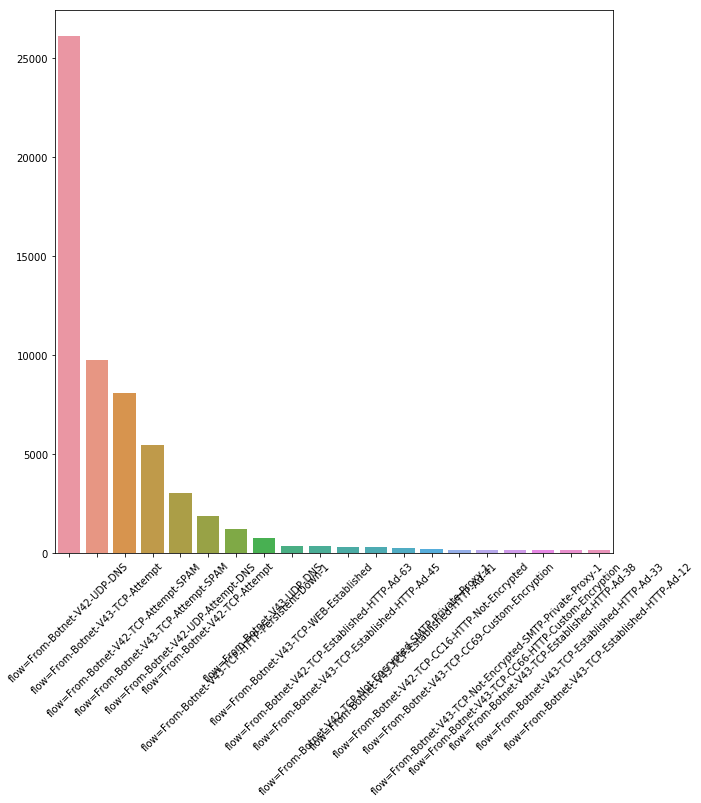

In [159]:
fig, ax = plt.subplots(figsize=(10, 10))

label_hist = sns.barplot(x=l, y=c, ax=ax)
plt.xticks(rotation=45)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text xticklabel objects>)


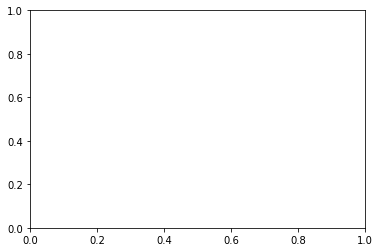

TypeError: object of type 'int' has no len()

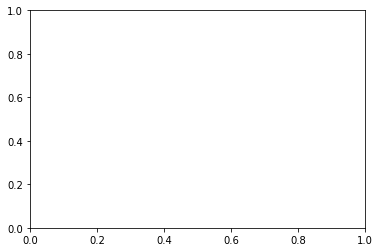

In [75]:
from importlib import reload
reload(plt)
%matplotlib inline

index = np.arange(len(l))
plt.xticks(len(l), l)
plt.xticks(rotation = 'vertical')
plt.xlabel('Type of Botnet')
plt.ylabel('# of occurences')
plt.title('Botnet label counts')
plt.bar(l, c, align='center', alpha=0.5)

### Aggregated flows, equivalent to "phrases"

The word2vec algorithm can also learn embeddings for phrases as well as single words for written language. The ideas I have surrounding "phrases" would be learning the embeddings for given windows of flows, if they were to present themselves in certain capacities within the captures flow data.

The current flow data that this notebook is based around are aggregated flows for bi-directional communication between endpoints. Exploiting something like capturing the 'phrase' of a flow, or thought another way, the bi-directional communication patterns that are contained within flow data might prove useful for application profiling, etc. through the use of application meta-data tracked through some sort of semi-supervised learning pipeline.


# Clustering

Now that we have some vector representations of occurences of flows within the captures that we have, we can run a clustering algorithm over them to see if we can humanly identify some of the groupings that have taken place. For this, we'll use kmeans within the scikit-learn package.

Kmeans has an objective function that intends to partition $n$ objects into $k$ clusters in which each object, $n$, belongs to the cluster with the nearest mean. This can be seen as :

$$ J = \sum_{j=1}^{k}\sum_{i=1}^{n} \| x_{i}^{(j)} - c_{j}\|^2 $$

Where $\| x_{i}^{(j)} - c_{j}\|^2$ is a chosen distance measure between a datapoint $x^{j}_{i}$ and the cluster center $c{j}$, is an indicator of the distance of the $n$ datapoints from their respective cluster $k$ centers. In this case, $k$ is a hyperparameter that can be used within the model to define how many cluster centroids should be trained over.

#### TODO :

<ul class="contains-task-list">
  <li class="task-list-item">
    <input class="task-list-item-checkbox" id="" type="checkbox"> Limitation for arrays larger than 16GB due to an underlying dependency that numpy has, need to investigate - this is why I'm only running kmeans on a subset of the overall model learned above </li>
    <input class="task-list-item-checkbox" id="" type="checkbox"> Dimensionality reduction of some kind over the data - 300 dimensional data isn't crazy high but might have some improved performance here as well. </li>
</ul>

In [77]:
flow_vectors = flow_model_labels.wv.vectors[0:20000][0]
flow_vectors.shape[0]

200

In [115]:
# Set k (number of clusters) to be 1/5 of the "vocabulary" size
# or an average of flows per cluster, this is a hyperparameter
# in kmeans that we can tweak later on

flow_vectors = flow_model_labels.wv.vectors[0:10000]
num_clusters = 75

# Initialize k-means object and use it to extract centroids

kmeans_clustering = cluster.KMeans(n_clusters = num_clusters, init="k-means++", n_jobs=-1)
idx = kmeans_clustering.fit_predict(flow_vectors)

# Create a flow / Index dictionary, mapping "vocabulary words" to
# a cluster number

In [116]:
flow_centroid_map = dict(zip(flow_model_labels.wv.index2word, idx))

In [122]:
for k,v in flow_centroid_map.items():
    if v == 3:
        print(k, v)

['udp', '147.32.86.51', '147.32.80.9', '53', 'flow=To-Background-UDP-CVUT-DNS-Server'] 3
['tcp', '147.32.86.51', '75.101.227.132', '80', 'flow=Background-TCP-Established'] 3


In [106]:
#Find some botnet labels to use for exploration of data

import operator
sorted_clusters = sorted(flow_centroid_map.items(), key=operator.itemgetter(1))

botnets = []

for i in sorted_clusters:
    if re.search(r"Botnet", i[0]):
        botnets.append(i)
        
botnets[0:10]

[("['tcp', '147.32.84.165', '205.188.59.193', '25', 'flow=From-Botnet-V42-TCP-Attempt-SPAM']",
  0),
 ("['tcp', '147.32.84.165', '64.12.138.161', '25', 'flow=From-Botnet-V43-TCP-Attempt-SPAM']",
  0),
 ("['tcp', '147.32.84.165', '31.192.109.161', '80', 'flow=From-Botnet-V43-TCP-CC56-HTTP-Not-Encrypted']",
  0),
 ("['tcp', '147.32.84.165', '74.125.93.27', '25', 'flow=From-Botnet-V43-TCP-Attempt-SPAM']",
  0),
 ("['tcp', '147.32.84.165', '74.125.127.27', '25', 'flow=From-Botnet-V42-TCP-Attempt-SPAM']",
  0),
 ("['tcp', '147.32.84.165', '98.137.54.237', '25', 'flow=From-Botnet-V43-TCP-Attempt-SPAM']",
  0),
 ("['tcp', '147.32.84.165', '98.139.54.60', '25', 'flow=From-Botnet-V43-TCP-Attempt-SPAM']",
  0),
 ("['tcp', '147.32.84.165', '216.157.130.15', '25', 'flow=From-Botnet-V43-TCP-Attempt-SPAM']",
  0),
 ("['tcp', '147.32.84.165', '205.188.103.1', '25', 'flow=From-Botnet-V43-TCP-Attempt-SPAM']",
  0),
 ("['udp', '147.32.84.165', '194.28.173.37', '53', 'flow=From-Botnet-V42-UDP-DNS']",
  0

In [81]:
# Look at members of clusters according to botnet memberships discovered above

cluster_members = []
for i in sorted_clusters:
    if i[1] == 73:
        cluster_members.append(i)
    
cluster_members[0:10]

[]

## Cluster visualization

Raw flow vectors $V_{f}$, created by word2vec, are embedded in dimensionality equivalent to the input layer of the shallow neural network that is used within the model. In our example we're using 

### t-SNE Visualization

Use t-SNE and matplotlib to visualize the clusters created using Word2Vec.

#### TODO :

<ul class="contains-task-list">
  <li class="task-list-item">
    <input class="task-list-item-checkbox" id="" type="checkbox"> Brief explanation of the tSNE algorithm and how it handles compressing higher dimensional data into 2 or 3 dimension for visualization </li>
</ul>

In [27]:
def perform_tsne(word_vector):
    tsne = manifold.TSNE(n_components=2, random_state=42)
    return tsne.fit_transform(word_vector)

In [28]:
#flow_model_reduced = TruncatedSVD(n_components=100, random_state=42).fit_transform(flow_model_1.syn0)
test_tsne = manifold.TSNE(n_components=2, learning_rate=50).fit_transform(flow_model_labels.wv.vectors[0:15000])

In [29]:
# Find all of the botnet flow indices

x = test_tsne[:,0]
y = test_tsne[:,1]

x_norm = scale(x)
y_norm = scale(y)

labels = flow_model_labels.wv.index2word[0:15000]
botnet_labels = []
botnet_flow_num = []
ind = 0

for label in labels:
    ind +=1 
    if label.find("Botnet") == -1:
        pass
    else:
        botnet_labels.append(label)
        botnet_flow_num.append(ind)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [33]:
#Find all of the botnet flow vectors from the tSNE model
botnet_flows = []

for ind in botnet_flow_num:
    botnet_flows.append(flow_model_labels.wv.vectors[ind-1])

len(botnet_flows) == len(botnet_flow_num)

True

In [35]:
compressed_botnet_flows_x = []

for ind in botnet_flow_num:
    compressed_botnet_flows_x.append(x_norm[ind-1])
    
compressed_botnet_flows_y = []

for ind in botnet_flow_num:
    compressed_botnet_flows_y.append(y_norm[ind-1])

x_norm = np.delete(x_norm, botnet_flow_num)
y_norm = np.delete(y_norm, botnet_flow_num)

525
525


TypeError: Object of type 'ndarray' is not JSON serializable

TypeError: Object of type 'ndarray' is not JSON serializable

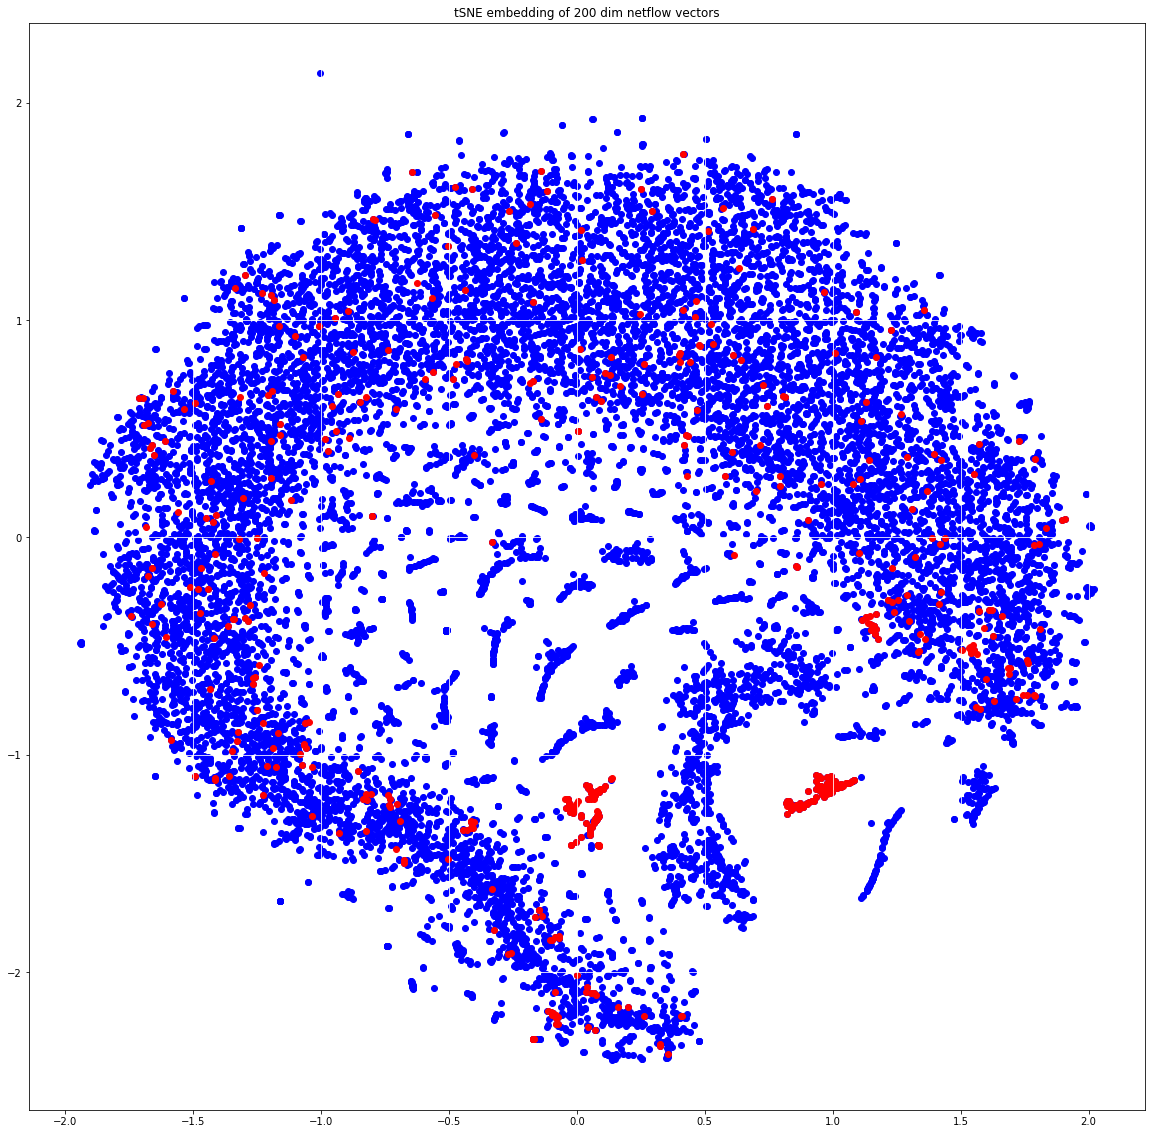

In [38]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_title("tSNE embedding of 200 dim netflow vectors")

mpld3_scatter_norm = ax.scatter(x_norm, y_norm, c='b')
mpld3_scatter_botnet = ax.scatter(compressed_botnet_flows_x, compressed_botnet_flows_y, c='r')
ax.grid(color='white', linestyle='solid')

tooltip_norm = mpld3.plugins.PointHTMLTooltip(labels=labels, points=mpld3_scatter_norm)
tooltip_botnet = mpld3.plugins.PointHTMLTooltip(labels=botnet_labels, points=mpld3_scatter_botnet)
mpld3.plugins.connect(fig, tooltip_norm, tooltip_botnet)
mpld3.save_html(fig, 'botnet_scaled_20x20.html')

## Things left to research / validate / test

<ul class="contains-task-list">
  <li class="task-list-item">
    <input class="task-list-item-checkbox" id="" type="checkbox"> Tune hyperparameters of models for all algorithms (word2vec, kmeans, tSNE) </li>
    <input class="task-list-item-checkbox" id="" type="checkbox"> Find fixes for limitations of larger datasets for tooling that has dependencies on numpy (kmeans, tSNE) </li>
</ul>

## ---- EVERYTHING BELOW THIS LINE FOR FUTURE USE ----

In [ ]:
# Generate hash for all flows within the dataset

flowdata_dict = {}

# Parallelize the hashing of flows

with concurrent.futures.ProcessPoolExecutor() as executor:
    for flow in executor.map(process_flow, flowdata_sample.iterrows()):
        flowdata_dict[flow[0]] = (flow[1], flow[2])

In [ ]:
## ONLY USE THIS BLOCK IF YOU WANT PER TO SORT FLOWS PER IP

# Lists for tcp and udp flows

tcp_flows = []
udp_flows = []

# Iterate over dataframe

for d in flowdata_sample.iterrows():
    if d[1][2] == 'tcp':
        
        #Append flow
        
        tcp_flows.append(d)
        
    elif d[1][2] == 'udp':
        udp_flows.append(d)

# Set for identifying unique IPs from flows

unique_per_proto = set()

for flow in tcp_flows:
    
    # Add unique SrcAddr to set for TCP flows
    
    unique_per_proto.add(flow[1][3])

for flow in udp_flows:
    
    # Add unique SrcAddr to set for UDP flows
    
    unique_per_proto.add(flow[1][3])

In [ ]:
## ONLY USE THIS BLOCK IF YOU WANT PER TO SORT FLOWS PER IP

# Set for unique IPs for overall flowset 
# Maintaining ordering of existing data
# Use this if we wanted a corpus per srcIP

unique_per_flow = set()

for d in flowdata_sample.iterrows():
    unique_per_flow.add(d[1][3])

In [ ]:
# Sort flows according to srcIP

ip_dicts = []

# Parallelization framework

with concurrent.futures.ProcessPoolExecutor() as executor:
    
    # pass in unique set to executor
    # Return dict from each process
    
    for d in executor.map(sort_ip_flow, unique_per_proto):
    
        # Roll all dicts up into list
        
        ip_dicts.append(d)

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#999; background:#fff;">
Created with Jupyter.
</footer>